Relative Band Power (RBP) of the five frequency bands of interest of the brain activity. The five frequency bands are defined as [2]:

Delta: 0.5–4 Hz

Theta: 4–8 Hz

Alpha: 8–13 Hz

Beta: 13–25 Hz

Gamma: 25–45 Hz

Moreover, according to the literature, AD patients exhibit changes in the RBP such as reduced alpha power and increased theta power.

## Loading the data or at least trying to

In [5]:
import numpy as np
import mne
import os
import zipfile

In [6]:
first_subject  = mne.io.read_raw_eeglab("/workspaces/EEG_Signal_Analysis-/ds004504-download/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set", preload=True)

In [7]:
print(first_subject)

<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~43.5 MiB, data loaded>


In [8]:
print(first_subject.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


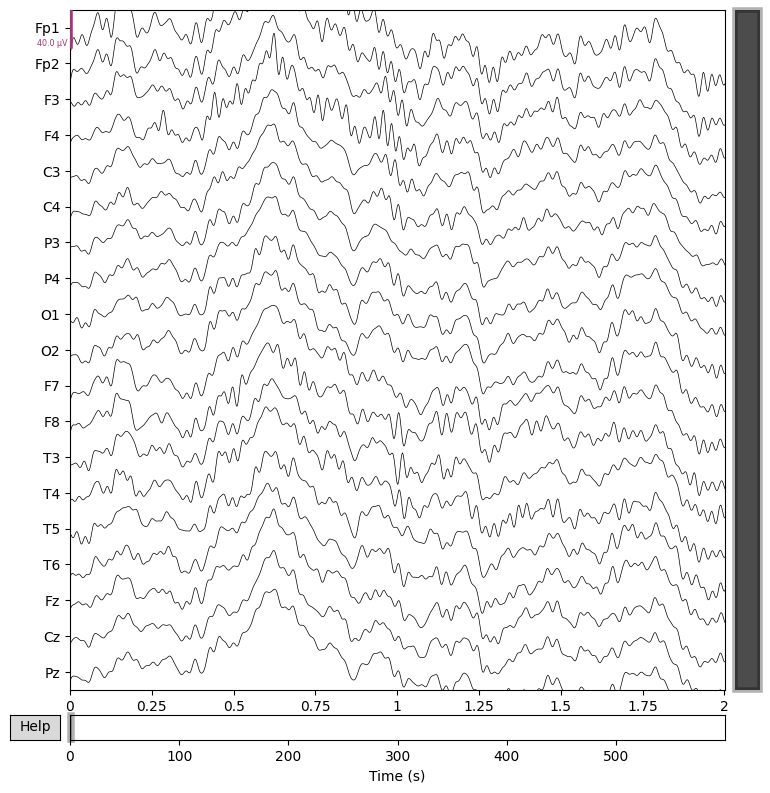

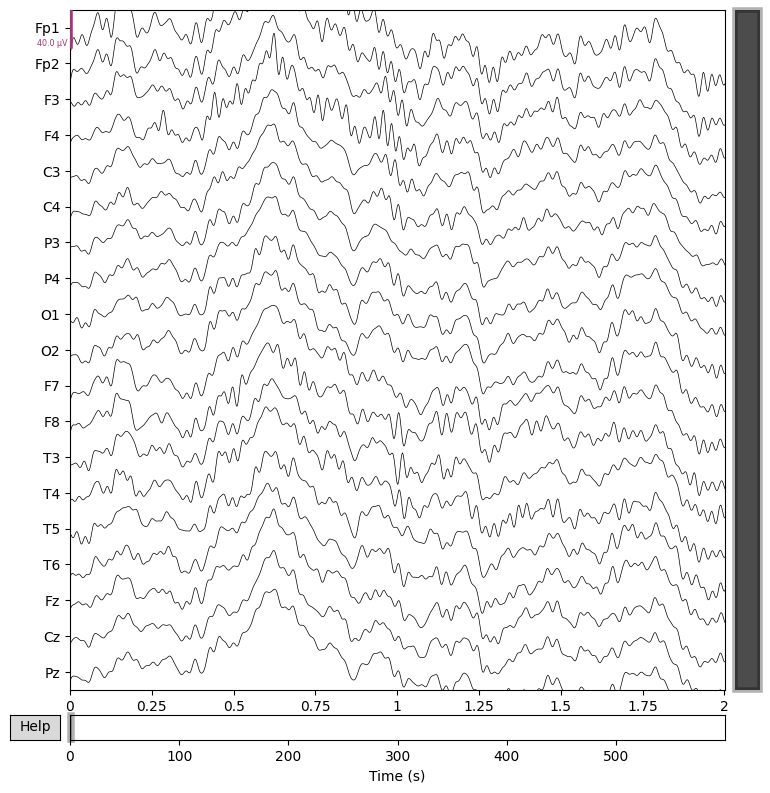

In [20]:
first_subject.plot(duration=2, n_channels=19, clipping=None)

## Preprocessing we have preprocessed data but we kind of know how to preprocess it 

Splitting time series into epochs 

In [38]:
# Define epoch length (e.g., 4 seconds)
epoch_length = 4 # in seconds (starting with 4 as it is a good sdtarting point for ressolution but it might not provide enough epochs to train the cnn, if that happens lower it to 2 seconds)

# Create epochs with fixed length (overlapping of 50%)
epochs = mne.make_fixed_length_epochs(first_subject, duration=epoch_length, overlap=epoch_length * 0.5)

epochs.drop_bad()

Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 298 events and 2000 original time points ...
0 bad epochs dropped


<Epochs | 298 events (all good), 0 – 3.998 s (baseline off), ~27 KiB, data not loaded,
 '1': 298>

In [39]:
duration = first_subject.n_times / first_subject.info['sfreq']
print(f"Duration: {duration:.2f} seconds")

Duration: 599.80 seconds


In [40]:
print(f"Number of epochs: {len(epochs)}")

Number of epochs: 298


Extracting Welch Features from Epochs 
to compute relative psd for each frequency band 

the PSD of an EEG epoch shows how much power (or energy) is present in the signal at each frequency. This is done by transforming the signal from the time domain to the frequency domain using methods like Fourier Transform (e.g., Welch’s method).

After applying the Fourier Transform to the signal, you obtain the frequency components of the signal, and the PSD represents the distribution of power across those frequencies.

*Power in Each Frequency Band:

After computing the PSD, you can then quantify the power present in specific frequency bands (such as delta, theta, alpha, beta, and gamma) by integrating the PSD over the frequency ranges that define those bands.

Delta: 0.5–4 Hz

Theta: 4–8 Hz

Alpha: 8–13 Hz

Beta: 13–30 Hz

Gamma: 30–50 Hz (or higher, depending on context)

*Absolute PSD:

The absolute PSD is the raw power at each frequency. It’s calculated by simply summing or averaging the power across different frequency bins for each band.

For example, if the PSD for an EEG signal is calculated across frequencies from 0 to 50 Hz, you could integrate the PSD within the theta band (4–8 Hz) to get the absolute power in that band for the specific epoch.

*Relative PSD:

The relative PSD normalizes the absolute PSD by dividing the power in each frequency band by the total power across the entire frequency range.

Formula:

Relative PSD
Power in Frequency Band
Total Power (0 Hz to highest frequency)
​
 
This gives you a proportional measure of how much of the total signal power is distributed across each frequency band, rather than just the raw power at that band.

The relative PSD helps to reduce the impact of overall signal amplitude or noise and focuses on the distribution of power across frequency bands, making it more stable for cross-subject comparisons or modeling purposes.



In [41]:
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.spectral import plot_power_spectra

# EEG frequency bands (Hz)
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 50)
}

# Extract sampling frequency from epochs (currently 500hz)
sfreq = epochs.info['sfreq']

# Get EEG data (n_epochs, n_channels, n_samples)
data = epochs.get_data()

print(sfreq)

# 398 epochs over 19 channels over 1500 data points (for 3 second epochs)
print(data.shape)

Using data from preloaded Raw for 298 events and 2000 original time points ...
500.0
(298, 19, 2000)


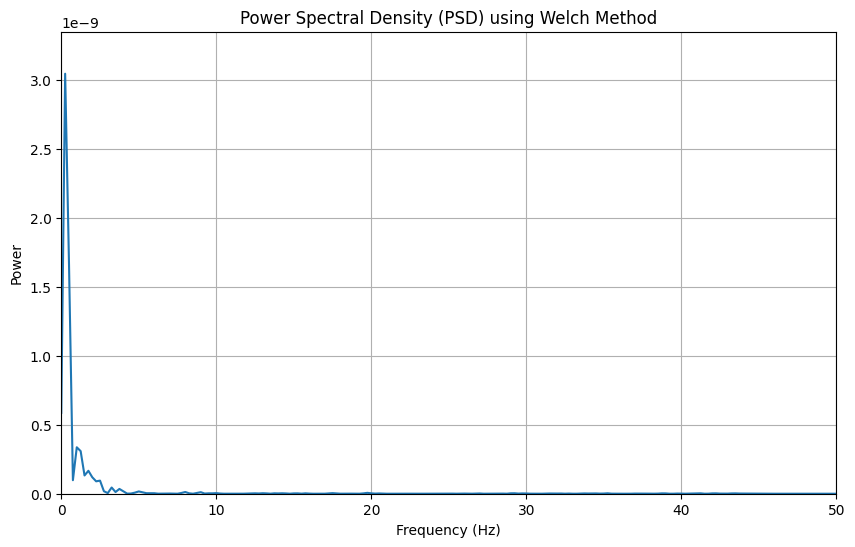

In [42]:
import matplotlib.pyplot as plt

# Select a single epoch and channel (e.g., epoch 0, channel 0)
epoch_data = data[0, 0]  # Select first epoch, first channel

# Compute PSD using Welch's method
f, psd = compute_spectrum(epoch_data, fs=500, method='welch', avg_type='median', nperseg=2000, noverlap=1000)

# Plot the PSD
plt.figure(figsize=(10, 6))
plt.plot(f, psd)
plt.title('Power Spectral Density (PSD) using Welch Method')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)  # Focus on low frequencies (delta to gamma bands)
plt.ylim(0, np.max(psd)*1.1)  # Adjust y-axis to avoid clipping
plt.grid(True)
plt.show()

In [43]:
print(epoch_length)

4


pipeline for a single subject relative and absolute psd extraction

In [44]:
data.shape

(298, 19, 2000)

In [45]:
ndatapoints = int(sfreq*epoch_length)
noverlap = ndatapoints//2

absolute_psd = []
relative_psd = []

for epoch in data: 
    epoch_abs_psd = []
    epoch_rel_psd = []

    for ch in epoch: 
        # Compute Welch PSD using NeuroDSP
        # The paper describing the dataset uses mean for its feature extraction as the data has been cleaned and filtered
        # Analyzes all frequencies maybe we could focus on only the most sensible ones to alzeimhers according to literature 
        f, psd = compute_spectrum(ch, fs=sfreq, method='welch', avg_type='mean', 
                                  nperseg = ndatapoints, noverlap = noverlap, 
                                  window='hamming')
        
        # Compute absolute PSD for each frequency band
        band_powers = [np.mean(psd[(f >= low) & (f < high)]) for low, high in bands.values()]
        epoch_abs_psd.append(band_powers)

        # Compute relative PSD
        total_power = np.sum(band_powers)  # Total power across all bands
        rel_powers = [bp / total_power if total_power > 0 else 0 for bp in band_powers]  # Normalize
        epoch_rel_psd.append(rel_powers)

    absolute_psd.append(epoch_abs_psd)
    relative_psd.append(epoch_rel_psd) 

abs_psd_all = np.array(absolute_psd)
rel_psd_all = np.array(relative_psd)

# Flatten features for 1d CNN input
absolute_psd_flat = abs_psd_all.reshape(abs_psd_all.shape[0], -1)
relative_psd_flat = rel_psd_all.reshape(rel_psd_all.shape[0], -1)

In [46]:
abs_psd_all.shape
rel_psd_all.shape

(298, 19, 5)

Hjorth parameters (often called Hjorth metrics), which are indeed popular features in EEG analysis and have been explored as potential biomarkers for Alzheimer's disease.

Hjorth parameters consist of three metrics:

* Activity: This is essentially the variance of the EEG signal and provides a measure of signal power.
* Mobility: This parameter estimates the mean frequency or the proportion of the standard deviation of the signal's first derivative to the standard deviation of the signal itself.
* Complexity: This assesses the change in frequency, giving an idea of the signal’s deviation from a pure sine wave (i.e., how “complicated” the signal is), and is computed as the ratio of the mobility of the derivative of the signal to the mobility of the signal itself.

Researchers have used these metrics as features because they are relatively simple to compute, are interpretable, and can capture important aspects of brain dynamics. In the context of Alzheimer’s disease, changes in these parameters—compared to healthy controls—may reflect alterations in neural activity and connectivity due to neurodegeneration.

Computing hjorth metrics over each channel and epoch

* Activity is computed as the variance of the time series.
* Mobility is computed as the square root of the variance of the first derivative divided by the variance of the original signal.
* Complexity is computed as the ratio of the mobility of the first derivative (that is, the mobility of dy/dt) to the mobility of the original signal.

In [ ]:
# where data is an epochs's (np.array): 3D array with shape (n_epochs, n_channels, n_times)
data.shape

(298, 19, 2000)

In [54]:
def get_hjorth_parameters(signal, sfreq): 
    """
    Parameters:
    signal (np.array): 1D array of the EEG time series (e.g., one channel data).
    sfreq (float): Sampling frequency in Hz.
    
    Returns:
    activity (float): Variance of the signal.
    mobility (float): Square root of the ratio of the variance of the signal's first derivative to the variance of the signal.
    complexity (float): Ratio of the mobility of the signal's first derivative to the mobility of the signal.
    """
    # Sampling interval
    dt = 1.0 / sfreq

    # 1. Activity: Variance of the signal
    activity = np.var(signal)

    # 2. First derivative (dy/dt) approximated by np.diff with scaling by dt
    dy = np.diff(signal) / dt
    # Mobility: sqrt( var(dy) / var(signal) )
    mobility = np.sqrt(np.var(dy) / activity) if activity > 0 else 0.0

    # 3. Second derivative (d^2y/dt^2)
    ddy = np.diff(dy) / dt

    # Compute mobility of the first derivative:
    # Avoid division by zero if variance of dy is zero.
    if np.var(dy) > 0:
        mobility_dy = np.sqrt(np.var(ddy) / np.var(dy))
    else:
        mobility_dy = 0.0

    # Complexity: mobility_dy / mobility
    complexity = mobility_dy / mobility if mobility > 0 else 0.0

    return activity, mobility, complexity


In [58]:
n_epochs, n_channels, _ = data.shape

activity_all = np.zeros((n_epochs, n_channels))
mobility_all   = np.zeros((n_epochs, n_channels))
complexity_all = np.zeros((n_epochs, n_channels))

for epoch_idx in range(n_epochs):
    for ch_idx in range(n_channels):
        signal = data[epoch_idx, ch_idx, :]
        act, mob, comp = get_hjorth_parameters(signal, sfreq)
        activity_all[epoch_idx, ch_idx] = act
        mobility_all[epoch_idx, ch_idx] = mob
        complexity_all[epoch_idx, ch_idx] = comp

activity_all.shape
mobility_all.shape 
complexity_all.shape


(298, 19)